# 기본 + 작은영역도 AREA 변수 추가

In [94]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [95]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.dirname(path)
path = os.path.join(path, "Daesamanlap\\ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [96]:
import warnings
warnings.filterwarnings(action='ignore')

In [97]:
#pd.set_option('display.max_rows', None)

In [98]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [99]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [100]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

In [101]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

In [102]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

In [103]:
level = 85

In [104]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

In [105]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

- 1차원으로 합치기

In [106]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [107]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

- 전용면적별세대수 채우기

In [108]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [109]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [110]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

In [111]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [112]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 연면적 / 전용면적은 나중에 drop

In [113]:
sample = train.groupby('단지코드').mean()[['전용면적']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['전용면적']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

train_one["연면적new"]=train_one.연면적
test_one["연면적new"]=test_one.연면적

train_one.loc[(train_one.연면적new<train_one.전용면적), "연면적new"]=np.nan
test_one.loc[(test_one.연면적new<test_one.전용면적), "연면적new"]=np.nan

In [114]:
#train_one.isna().sum() # 63

In [115]:
#test_one.isna().sum() #23

In [116]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2) # 12345 중에 2가 제일 좋음

im=train_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
im = pd.DataFrame(imputer.fit_transform(im),
                     columns = im.columns)

train_one["연면적new"]=im["연면적new"]

imp=test_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
imp = pd.DataFrame(imputer.fit_transform(imp),
                     columns = imp.columns)

test_one["연면적new"]=imp["연면적new"]

### 7) 대형전용면적 총개수

In [117]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [118]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

In [119]:
col = ['단지명','도로명주소','subway_name','임대상가', '전용면적']

In [120]:
train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

## 2. 데이터 나누기: 단지내주차면수 987 기준

In [121]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [122]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

## train up 쪽 데이터를 늘려보자

In [123]:
pd.concat([pd.DataFrame(train_one.단지내주차면수.describe()),
 pd.DataFrame(test_one.단지내주차면수.describe()) ], axis=1)

,단지내주차면수,단지내주차면수
count,414.000000,147.000000
mean,586.330918,558.387755
std,363.665625,321.009953
min,13.000000,29.000000
25%,318.250000,313.000000
50%,517.000000,499.000000
75%,785.750000,726.000000
max,1798.000000,1696.000000


In [124]:
train_up2 = train_one[(train_one['단지내주차면수']<987)&(train_one['단지내주차면수']>=517)].reset_index(drop=True)

In [125]:
train_up2["diff"]=abs(train_up2.단지내주차면수-train_up2.등록차량수)

In [126]:
train_up2["diff"].describe()

count    156.000000
mean     160.647436
std      132.156008
min        0.000000
25%       67.500000
50%      129.000000
75%      215.250000
max      709.000000
Name: diff, dtype: float64

In [127]:
train_up2=train_up2[train_up2["diff"]>215]

In [128]:
train_up=pd.concat([train_up, train_up2], axis=0)

In [129]:
train_up=train_up.drop(columns=["diff"]).reset_index(drop=True)

In [131]:
#train_up

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [132]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [133]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [134]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

In [136]:
#train_up

In [ ]:
#test[test.단지코드=="C1692"]

In [ ]:
#test[test.단지코드=="C2267"]

In [ ]:
#X_cor = train_up.select_dtypes(include="number")
#plt.subplots(figsize=(20,15))
#sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

In [ ]:
#ig, axes = plt.subplots(8,5, figsize= (16,32))
#i = 0
#for f in col:
#    c = i % 5
#    r = i // 5   
#    axes[r,c].hist(x = f, bins =30, data = train_up)
#    plt.xlabel(f)
#    i += 1
#plt.show()

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler
#robustScaler = RobustScaler()
#standardScaler = StandardScaler()
#minMaxScaler = MinMaxScaler()

In [ ]:
#train_up.select_dtypes(include="number")

In [ ]:
#scaler = robustScaler
#loc_f = ['총세대수', '공가수', '연면적' , "임대료", "임대보증금"]
#train_up.loc[:, loc_f] = scaler.fit_transform(train_up[loc_f])
#test_up.loc[:, loc_f] = scaler.transform(test_up[loc_f])

## 3. 모델링

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [138]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [43]:
X = train_down.drop(columns=['단지코드','등록차량수', "연면적new"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = train_down['등록차량수']

In [44]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

MAE :  105.37534703159452


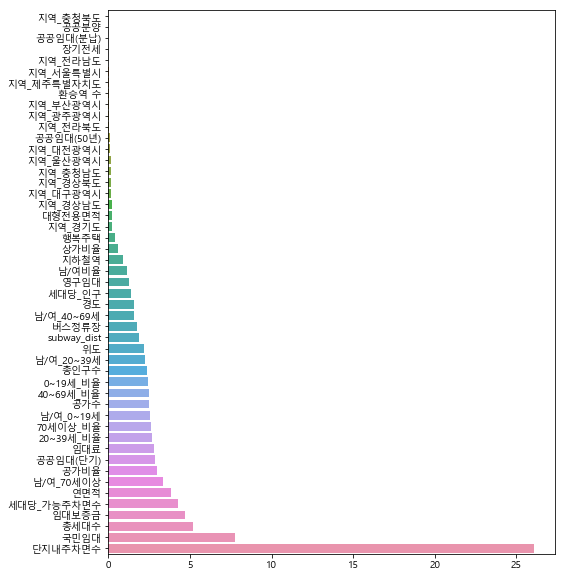

In [45]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))

### 2) train/test up

In [152]:
#train_up

In [139]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

MAE :  310.5252983785741


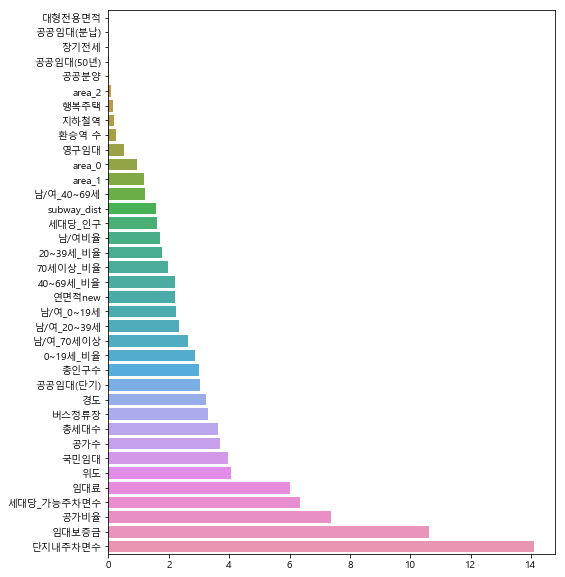

In [140]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))

In [144]:
df=pd.merge(pd.DataFrame(pred_up,index=[0]).T.reset_index(),
        pd.DataFrame(train_up.단지코드.reset_index(drop=True)).reset_index(),
         on="index")

df=df.drop(columns=["index"])
df.columns=["pred_up", "단지코드"]

In [145]:
df_up=pd.merge(train_one, df, on="단지코드", how='inner')
df_up["diff"]=df_up.등록차량수-df_up.pred_up

In [152]:
#df_up[["단지코드","총세대수","단지내주차면수","등록차량수","pred_up","공가수",
#                       "diff","세대당_가능주차면수"]].sort_values("등록차량수")

In [160]:
#fig, ax = plt.subplots(figsize=(30,5))
#sns.kdeplot(data=df_up,x='등록차량수')
#sns.kdeplot(data=df_up,x='pred_up')

## 4. Final prediction

In [141]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [142]:
X_train = train_down.drop(columns=['단지코드','등록차량수','연면적new'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [143]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [144]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적new', '위도', '경도',
       'subway_dist', '환승역 수',  '총인구수','세대당_인구','남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']

In [145]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역', '연면적'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)
X_test = X_test[col]

cb_up = CatBoostRegressor(random_state=2021,
                          verbose=False,
                          loss_function='MAE').fit(X_train,y_train)
pred_up = cb_up.predict(X_test)

In [146]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

In [147]:
#cb_up.get_all_params()

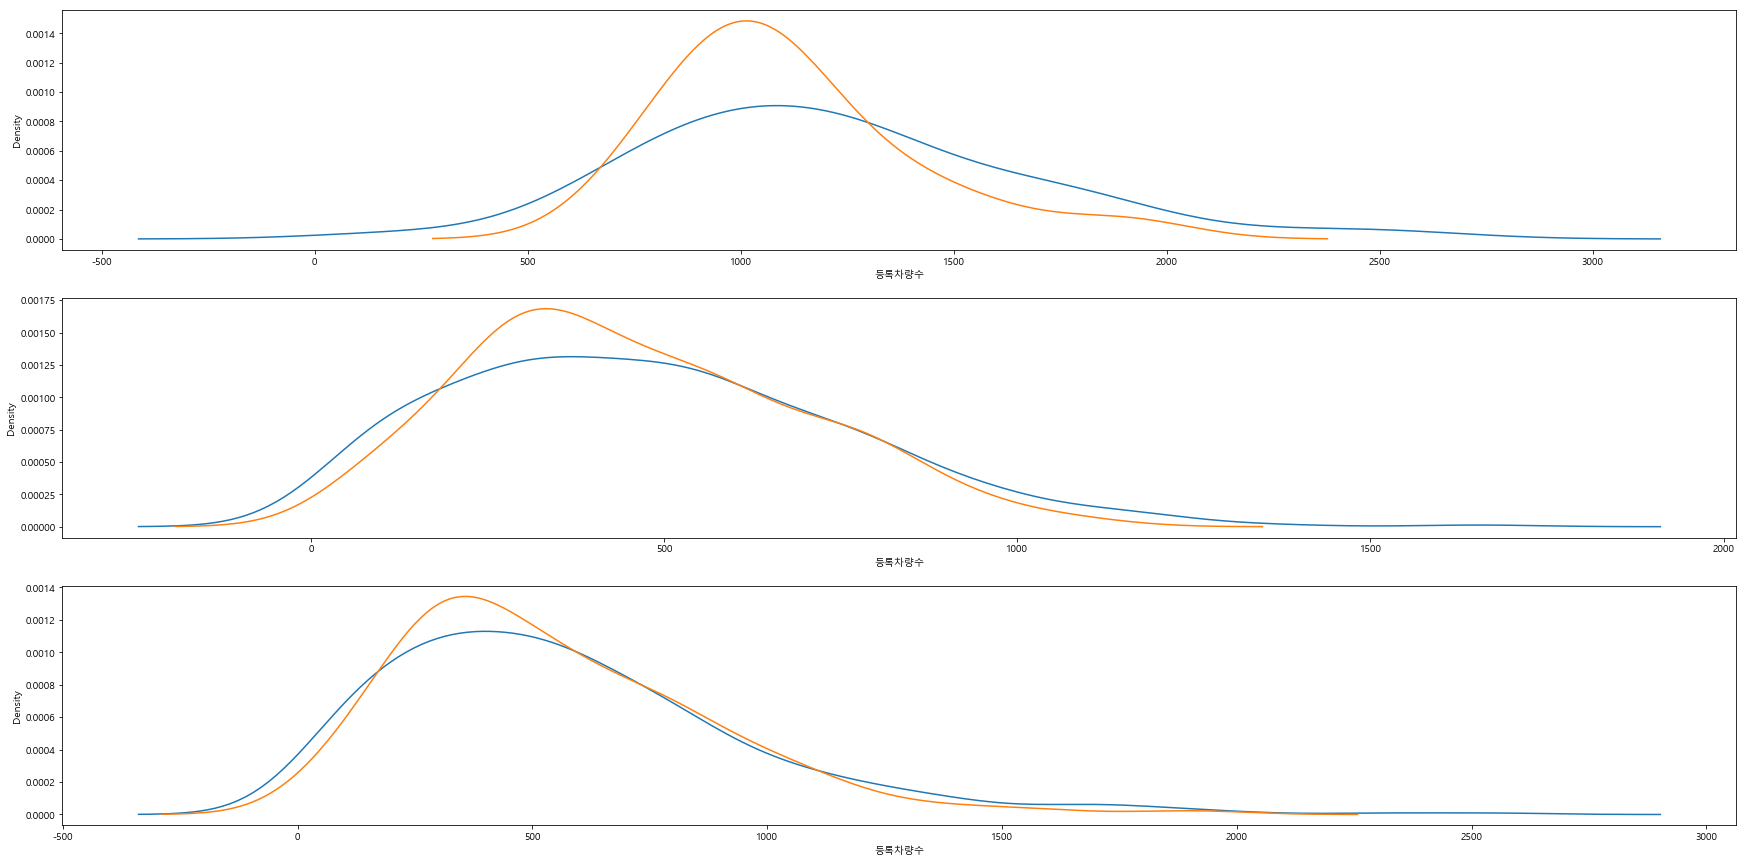

In [148]:
fig, ax = plt.subplots(3,1,figsize=(30,15))
sns.kdeplot(data=train_one[train_one.단지내주차면수>987],x='등록차량수',ax=ax[0])
sns.kdeplot(data=get_pred()[1],x='num',ax=ax[0])
sns.kdeplot(data=train_down,x='등록차량수',ax=ax[1])
sns.kdeplot(data=get_pred()[0],x='num',ax=ax[1])
sns.kdeplot(data=train_one,x='등록차량수',ax=ax[2])
sns.kdeplot(data=get_pred()[2],x='num',ax=ax[2])

## 5. 기존 score와 비교 및 제출

In [158]:
def score(mse):
    score = pd.read_csv("result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score_up

In [159]:
score(94)

전체 MAE :  11.653201453931908
큰 영역 MAE :  90.15897947652181
작은 영역 MAE :  2.8703719068268185e-08


,code,num_x,num_y
128,C1128,1149.871199,1154.021720
129,C1332,1333.142477,1323.633667
130,C1563,1794.856733,1899.596715
131,C1794,1007.060101,1033.769866
132,C1152,866.384128,755.516021
133,C2555,1464.524065,1577.961527
134,C2608,1111.143551,1134.022892
135,C1617,1090.664885,958.640896
136,C1250,1259.755347,1025.682285
137,C2028,1030.693449,980.372932


In [58]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [59]:
sub = submit()
sub.to_csv("result/result_area.csv",index=False)

In [ ]:
res2 = score(96)

In [ ]:
res1 = score(98)

In [ ]:
res3 = score(99)

In [ ]:
res4 = score(100)